In [202]:
import pandas as pd
from datetime import datetime
from datetime import time
import numpy as np

In [203]:
df = pd.read_csv('./prediction.csv')
df['day'] = df['day'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [204]:
df.head()

,Unnamed: 0,production,day
0,0,3.863014e+06,2021-11-06
1,1,3.836858e+06,2021-11-07
2,2,3.371922e+06,2021-11-08
3,3,3.766874e+06,2021-11-09
4,4,3.708427e+06,2021-11-10


In [205]:
df_sunshine = pd.read_csv('./sunshine_hourly.csv')
df_sunshine['datetime'] = df_sunshine['datetime'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_sunshine['day'] = df_sunshine['datetime'].map(lambda x: x.replace(second=0, microsecond=0, minute=0, hour=0, tzinfo=None))
df_sunshine.head()

,Unnamed: 0,sunshine,datetime,day
0,0,0,2021-11-06 00:00:00,2021-11-06
1,1,0,2021-11-06 01:00:00,2021-11-06
2,2,0,2021-11-06 02:00:00,2021-11-06
3,3,0,2021-11-06 03:00:00,2021-11-06
4,4,0,2021-11-06 04:00:00,2021-11-06


In [206]:
df_sunrise_set = pd.read_csv('./../../raw-data/weather/SunsetSunrise.csv', sep=';')
df_sunrise_set['day'] = df_sunrise_set['Date'].map(lambda x: datetime.strptime(x, '%d.%m.%Y'))

In [207]:
df_sunshine = df_sunshine.merge(df, on='day', how='left')

In [208]:
df_sunshine = df_sunshine.merge(df_sunrise_set, on='day', how='left')
df_sunshine.head()

,Unnamed: 0_x,sunshine,datetime,day,Unnamed: 0_y,production,Date,Sunrise,Sunset,Daylength
0,0,0,2021-11-06 00:00:00,2021-11-06,0,3.863014e+06,06.11.2021,07:14:03,16:58:27,9h 44m 24s
1,1,0,2021-11-06 01:00:00,2021-11-06,0,3.863014e+06,06.11.2021,07:14:03,16:58:27,9h 44m 24s
2,2,0,2021-11-06 02:00:00,2021-11-06,0,3.863014e+06,06.11.2021,07:14:03,16:58:27,9h 44m 24s
3,3,0,2021-11-06 03:00:00,2021-11-06,0,3.863014e+06,06.11.2021,07:14:03,16:58:27,9h 44m 24s
4,4,0,2021-11-06 04:00:00,2021-11-06,0,3.863014e+06,06.11.2021,07:14:03,16:58:27,9h 44m 24s


In [209]:
temp = df_sunshine
temp['Sunrise'] = temp['Sunrise'].map(lambda x: datetime.strptime(x, '%H:%M:%S').hour)
temp['Sunset'] = temp['Sunset'].map(lambda x: datetime.strptime(x, '%H:%M:%S').hour + 1)
temp

,Unnamed: 0_x,sunshine,datetime,day,Unnamed: 0_y,production,Date,Sunrise,Sunset,Daylength
0,0,0,2021-11-06 00:00:00,2021-11-06,0,3.863014e+06,06.11.2021,7,17,9h 44m 24s
1,1,0,2021-11-06 01:00:00,2021-11-06,0,3.863014e+06,06.11.2021,7,17,9h 44m 24s
2,2,0,2021-11-06 02:00:00,2021-11-06,0,3.863014e+06,06.11.2021,7,17,9h 44m 24s
3,3,0,2021-11-06 03:00:00,2021-11-06,0,3.863014e+06,06.11.2021,7,17,9h 44m 24s
4,4,0,2021-11-06 04:00:00,2021-11-06,0,3.863014e+06,06.11.2021,7,17,9h 44m 24s
...,...,...,...,...,...,...,...,...,...,...
163,19,0,2021-11-12 19:00:00,2021-11-12,6,3.393868e+06,12.11.2021,7,17,9h 27m 47s
164,20,0,2021-11-12 20:00:00,2021-11-12,6,3.393868e+06,12.11.2021,7,17,9h 27m 47s
165,21,0,2021-11-12 21:00:00,2021-11-12,6,3.393868e+06,12.11.2021,7,17,9h 27m 47s
166,22,0,2021-11-12 22:00:00,2021-11-12,6,3.393868e+06,12.11.2021,7,17,9h 27m 47s


In [210]:
temp['after_sunrise'] = temp['datetime'].map(lambda x: x.hour) - temp['Sunrise']
temp['before_sunset'] = temp['datetime'].map(lambda x: x.hour) - temp['Sunset']


In [211]:
sun_peak_inv = 1 / ((temp['after_sunrise'] - temp['before_sunset']) / 2)

In [212]:
temp['prediction'] = (temp['after_sunrise'] * sun_peak_inv / (temp['after_sunrise'] - temp['before_sunset']) * temp['sunshine'] / 60 * temp['production'])

<AxesSubplot:xlabel='datetime'>

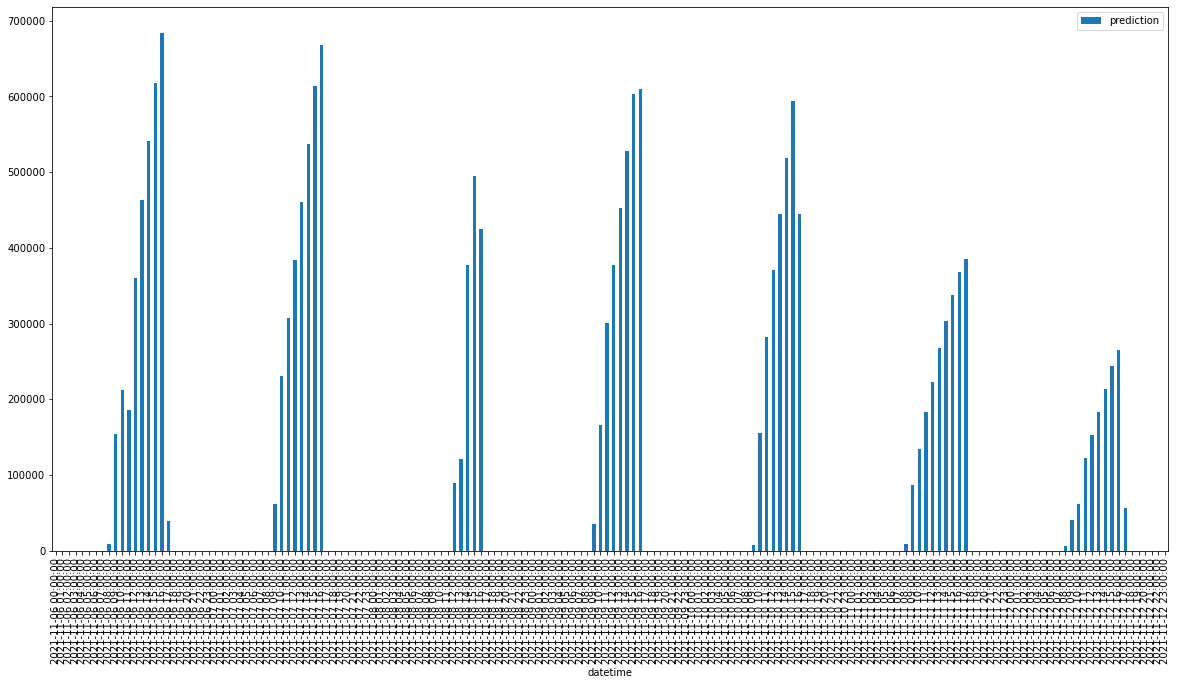

In [213]:
temp.plot(kind='bar', x='datetime', y='prediction', figsize=(20,10))

In [214]:
result = temp[['datetime', 'prediction']]

In [215]:
timestamp = list(result['datetime'].map(lambda x: x.isoformat()))
power_index = list(np.array(result['prediction']))
day = list(df['day'].map(lambda x: x.isoformat()))
day_power = list(df['production'])

In [216]:
result = {
    'series': [
        {
            'name': 'timestamp',
            'data': timestamp
        },
        {
            'name': 'powerIndex',
            'data': power_index
        },
        {
            'name': 'Day',
            'data': day
        },
        {
            'name': 'powerIndexDay',
            'data': day_power
        }
    ]
}


In [217]:
import json


with open('./sunprediction.json', 'w+') as outfile:
    json.dump(result, outfile)